# Mental Health Analyis using Text Data

This notebook contains code for analysing types Mental health problem problem.

The data was downloaded from Kaggle, you can access it from [here](https://www.kaggle.com/datasets/neelghoshal/reddit-mental-health-data?resource=download)

First, we will perform series of analysis on textual data.  
Secondly, we will try to create a machine learning model using different approaches to predict the mental health problems.  
Lastly, we use deep learning approaches to solve the task.

The class labels are as follows:

| Label | Description |
| --- | --- |
| 0 | Stress |
|1 | Depression |
|2 | Bipolar disorder|
|3 | Personality disorder|
|4|Anxiety|

# Importing and Cleaning Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data.csv')

# Insert into Database before processing

In [45]:
def insert_df_into_db(collection_name, df) -> None:
    from pymongo import MongoClient
    from dotenv import load_dotenv
    import os

    load_dotenv(dotenv_path="../.env")
    conn_str = os.getenv('CONN_STR')
    
    client = MongoClient(conn_str)
    db = client['PAI-Project']
    collection = db[collection_name]

    from json import loads, dumps

    documents = df.to_json(orient='records')
    parsed = loads(documents)
    collection.insert_many(parsed)

In [44]:
insert_df_into_db('TextDataUncleaned', df)

In [46]:
df.head()

,Unnamed: 0,text,title,target
0,0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1
1,1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1
2,2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1
3,3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1
4,4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1


Data has an unnamed column which is the index of the sample. So, it can be dropped

In [47]:
df.drop('Unnamed: 0', axis=1, inplace=True)

**Checking Null Values**

In [48]:
df.isna().sum()

text      350
title       0
target      0
dtype: int64

So, solve this problem we can concatinate the text and title, so that we will have single column and we wont have any null values.

In [49]:
inps = []

for title, text in zip(df['title'], df['text']):
    if isinstance(text, float):
        text = ''
    inps.append(title + '\n\n' + text)

df['input'] = inps

In [50]:
df.head()

,text,title,target,input
0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1,"Regular check-in post, with information about ..."
1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1,Our most-broken and least-understood rules is ...
2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1,"I haven’t been touched, or even hugged, in so ..."
3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1,Being Depressed is Embarrassing\n\nI’m just so...
4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1,I'm desperate for a friend and to feel loved b...


In [51]:
df.drop(['text', 'title'], axis=1, inplace=True)

In [52]:
df.head()

,target,input
0,1,"Regular check-in post, with information about ..."
1,1,Our most-broken and least-understood rules is ...
2,1,"I haven’t been touched, or even hugged, in so ..."
3,1,Being Depressed is Embarrassing\n\nI’m just so...
4,1,I'm desperate for a friend and to feel loved b...


## Insert Cleaned data into database

In [53]:
insert_df_into_db('TextDataCleaned', df)

Data has been ready for analysis and machine learning training.

## Text Preprocessing

In [65]:
import nltk
from nltk.corpus import stopwords
import re

In [66]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/notaryanramani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/notaryanramani/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [67]:
stopwords = set(stopwords.words('english'))

In [68]:
from tqdm import tqdm

In [72]:
def clean_text(texts):
    clean_texts = []
    for text in tqdm(texts):
        ct = text.lower()
        words = nltk.word_tokenize(ct)
        words = [word for word in words if word not in stopwords]
        ct = ' '.join(words)
        clean_texts.append(ct)
    return clean_texts

In [73]:
text = clean_text(df['input'])

100%|█████████████████████████████████████| 5957/5957 [00:05<00:00, 1189.02it/s]


In [74]:
df['clean_text'] = text

# Generating Word Cloud

In [76]:
corpus = {}

for cls in df['target']:
    lt = df[df['target'] == cls]['clean_text']
    crps = ' '.join(lt)
    corpus[cls] = crps

In [78]:
itoc = {
    0: 'Stress',
    1: 'Depression',
    2: 'Bipolar disorder',
    3: 'Personality disorder',
    4: 'Anxiety'
}

In [77]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

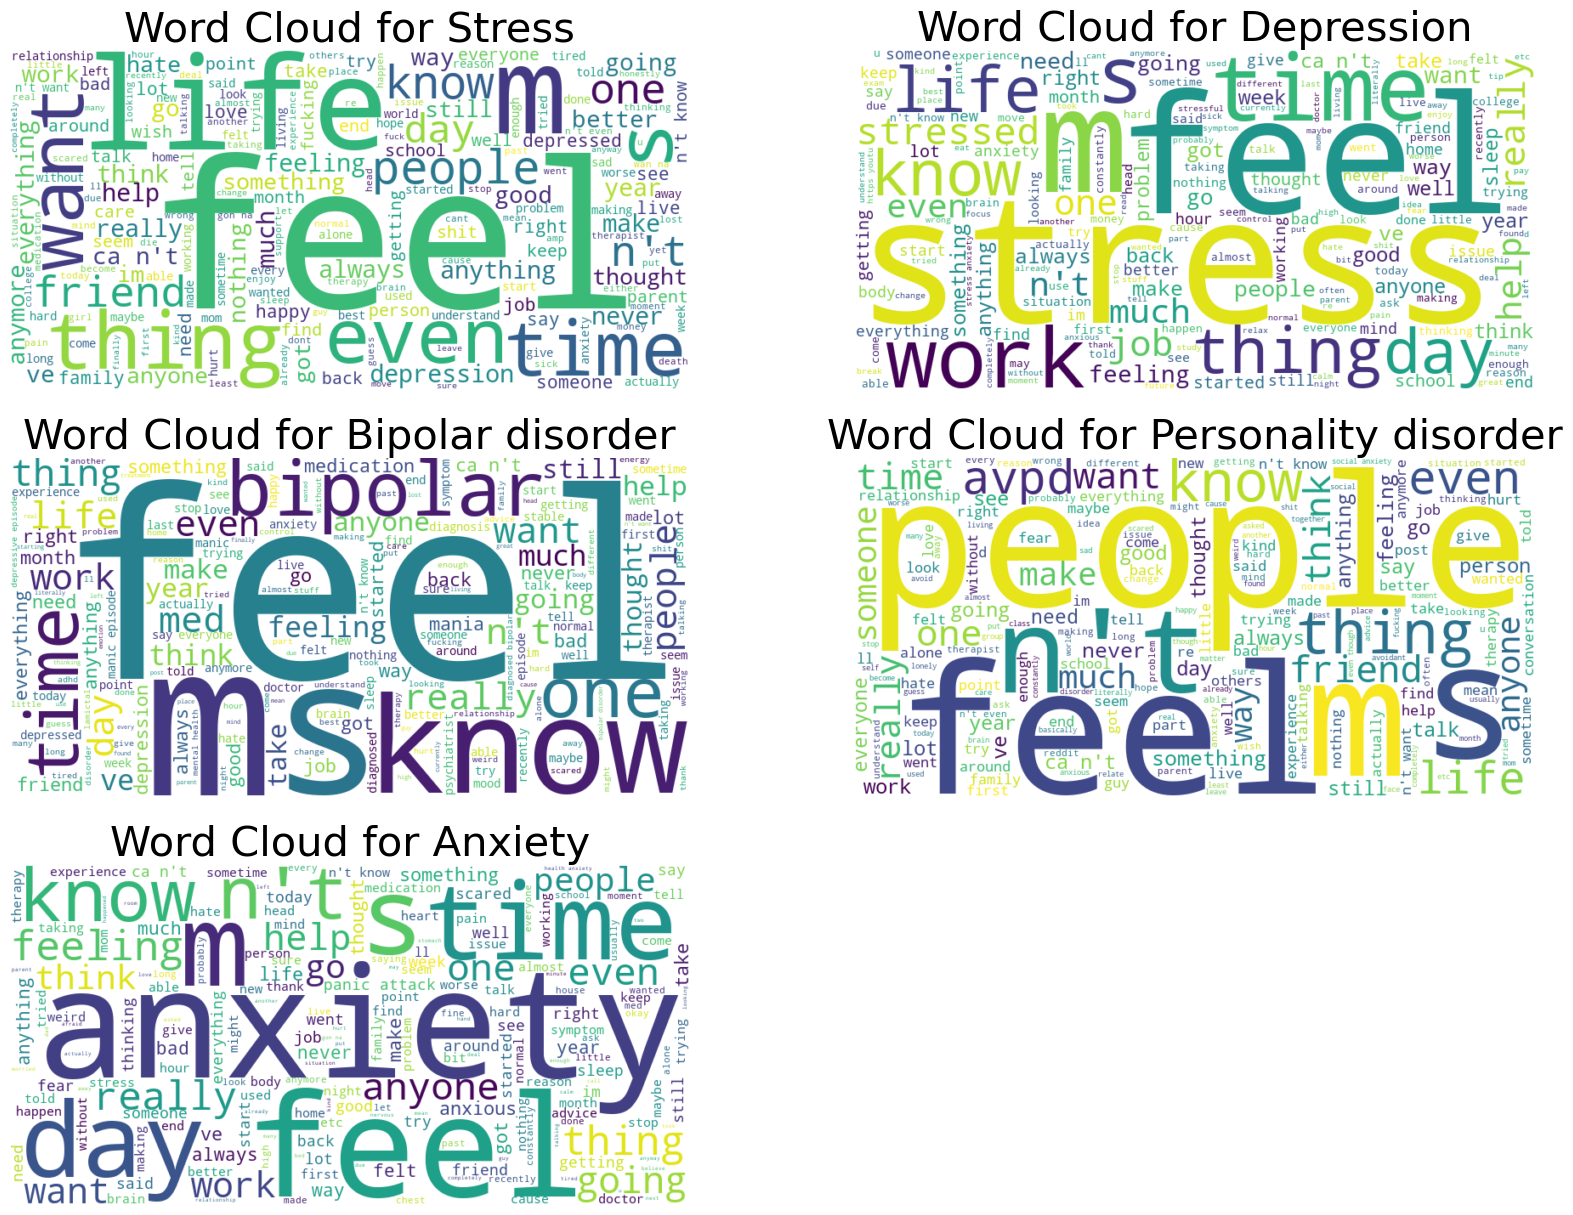

In [89]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, (cls, text) in enumerate(corpus.items()):
    cloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    axes[i].imshow(cloud, interpolation='bilinear')
    axes[i].set_title('Word Cloud for ' + itoc[i], fontsize=30)
    axes[i].axis('off')
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

axes[5].axis('off')

plt.show()

## Lemmetization

In [90]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/notaryanramani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/notaryanramani/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [94]:
lemmatizer = WordNetLemmatizer()

In [97]:
def lemmatize_text(tweets):
    lem_tweets = []
    for tweet in tqdm(tweets):
        lem_words = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(tweet)]
        lem_tweet = ' '.join(lem_words)
        lem_tweets.append(lem_tweet)
    return lem_tweets

In [98]:
df['lem_text'] = lemmatize_text(df['clean_text'])

100%|█████████████████████████████████████| 5957/5957 [00:05<00:00, 1102.51it/s]


## Data Transformation

In [99]:
X = df['lem_text']
y = df['target']

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [103]:
tfidf = TfidfVectorizer(max_features = 5000)

In [104]:
tfidf.fit(X_train)

TfidfVectorizer(max_features=5000)

In [106]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Model Training

In [105]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report

In [107]:
def evaluation_pipeline(m):
    m.fit(X_train, y_train)

    y_pred = m.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f'Results for {m.__class__.__name__}:\n\n')
    print(f'Accuracy Score: {acc}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix :\n{cm}\n')
    print(f'Classification Report: \n{cr}')

In [108]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()

evaluation_pipeline(log)

Results for LogisticRegression:


Accuracy Score: 0.7760067114093959
F1 Score: 0.7781835915886774
Confusion Matrix :
[[191  13   3  17  12]
 [  5 200  13  33  14]
 [  2  21 164  16   8]
 [  8  32   8 173   8]
 [  8  22   8  16 197]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       236
           1       0.69      0.75      0.72       265
           2       0.84      0.78      0.81       211
           3       0.68      0.76      0.71       229
           4       0.82      0.78      0.80       251

    accuracy                           0.78      1192
   macro avg       0.79      0.78      0.78      1192
weighted avg       0.78      0.78      0.78      1192



In [109]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

evaluation_pipeline(mnb)

Results for MultinomialNB:


Accuracy Score: 0.7399328859060402
F1 Score: 0.742118106782839
Confusion Matrix :
[[169  24   3  19  21]
 [  0 221  10  20  14]
 [  2  30 153  12  14]
 [  7  41   9 166   6]
 [  9  32  12  25 173]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       236
           1       0.64      0.83      0.72       265
           2       0.82      0.73      0.77       211
           3       0.69      0.72      0.70       229
           4       0.76      0.69      0.72       251

    accuracy                           0.74      1192
   macro avg       0.76      0.74      0.74      1192
weighted avg       0.76      0.74      0.74      1192



Logistic Regression performs better for this task